# Imports

In [ ]:
!pip install ipywidgets  -q
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider

## Constants

In [ ]:
# Constants
k_red = np.log(2) / (19/60)  # Time rate for Pfr -> Pr
k_red_reverse = np.log(2) / (210/60)  # Time rate for Pr -> Pfr
k_blue = np.log(2) / (5/60)  # Time rate for CRY2 to become active
k_blue_reverse = np.log(2) / (12.5/60)  # Time rate for CRY2 to become inactive
k_YFP = 0.2  # Max YFP production rate

deg_BphP1 = 0.005  # Degradation rate for BphP1
deg_CRY2 = 0.005  # Degradation rate for CRY2
deg_YFP = 0.005  # Degradation rate for YFP

BphP1_total = 4  # Total concentration of BphP1
CRY2_total = 4  # Total concentration of CRY2

n = 3  # Hill coefficient
K1 = 0.5 * BphP1_total  # K constant for BphP1 Hill equation
K2 = 0.5 * CRY2_total  # K constant for CRY2 Hill equation

## ODE Model Function - d(YFP)/dt

In [ ]:
def ode_model(state, t, I_red, I_blue):
  '''
  Returns d(YFP)/dt.
  '''
  [BphP1_Pr, CRY2_active, YFP] = state

  BphP1_Pfr = BphP1_total - BphP1_Pr
  CRY2_inactive = CRY2_total - CRY2_active

  d_BphP1_Pr = (k_red * I_red * BphP1_Pfr) - (k_red_reverse * BphP1_Pr) - (deg_BphP1 * BphP1_Pr)
  d_CRY2_active = (k_blue * I_blue * CRY2_inactive) - (k_blue_reverse * CRY2_active) - (deg_CRY2 * CRY2_active)
  d_YFP = k_YFP * (BphP1_Pr ** n / (K1 ** n + BphP1_Pr ** n)) * (CRY2_active ** n / (K2 ** n + CRY2_active ** n)) - deg_YFP * YFP

  return [d_BphP1_Pr, d_CRY2_active, d_YFP]

## Solve ODE

In [ ]:
# Initializations
initial_state = [0.0, 0.0, 0.0]  # BphP1 (active as Pr), CRY2 (active), and YFP
t = np.arange(0, 2000)  # Timesteps

# Solve ODEs
conditions = {
  'No light': (0, 0),
  'Red only': (1, 0),
  'Blue only': (0, 1),
  'Both lights': (1, 1)
}

results = {}

for label, (I_red, I_blue) in conditions.items():
  solution = odeint(ode_model, initial_state, t, args=(I_red, I_blue))
  results[label] = solution

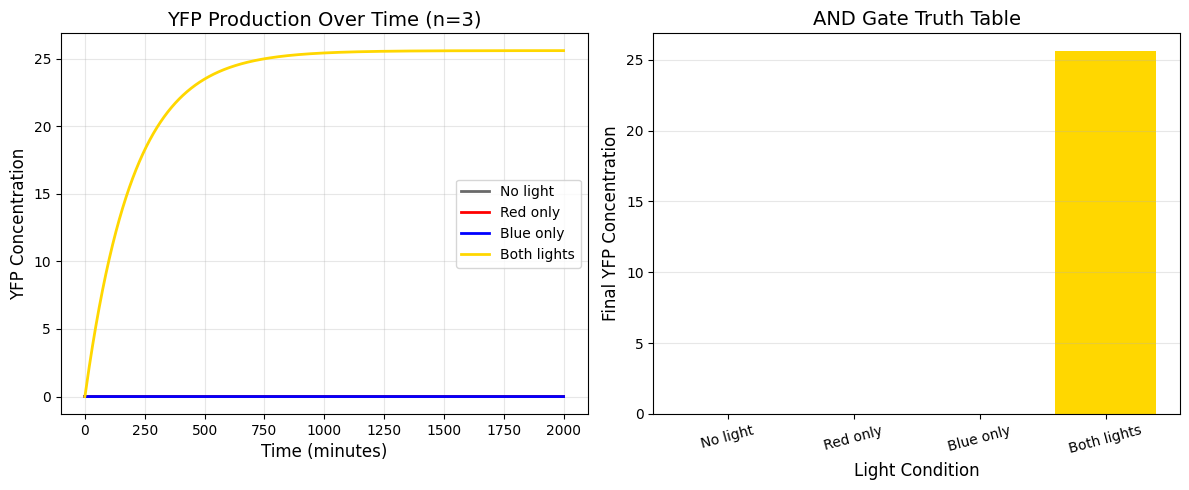

In [ ]:
# Plot 1: Time courses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
color_map = {
  'No light': 'dimgray',
  'Red only': 'red',
  'Blue only': 'blue',
  'Both lights': 'gold'
}

for label, solution in results.items():
  plt.plot(t, solution[:, 2], label=label, linewidth=2, color=color_map[label])
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('YFP Concentration', fontsize=12)
plt.title(f'YFP Production Over Time (n={n})', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Truth table with matching colors
plt.subplot(1, 2, 2)
final_YFP = {label: solution[-1, 2] for label, solution in results.items()}
colors = [color_map[label] for label in final_YFP.keys()]
plt.bar(final_YFP.keys(), final_YFP.values(), color=colors)
plt.xlabel('Light Condition', fontsize=12)
plt.ylabel('Final YFP Concentration', fontsize=12)
plt.title('AND Gate Truth Table', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()